In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler


      file_name  width  height  x1  y1   x2   y2  category
0  000_0001.png    134     128  19   7  120  117         0
1  000_0002.png    165     151  23  12  149  138         0
2  000_0003.png    128     122  22  14  116  105         0
3  000_0010.png     80      73  14   8   67   63         0
4  000_0011.png    186     174  36  15  155  157         0


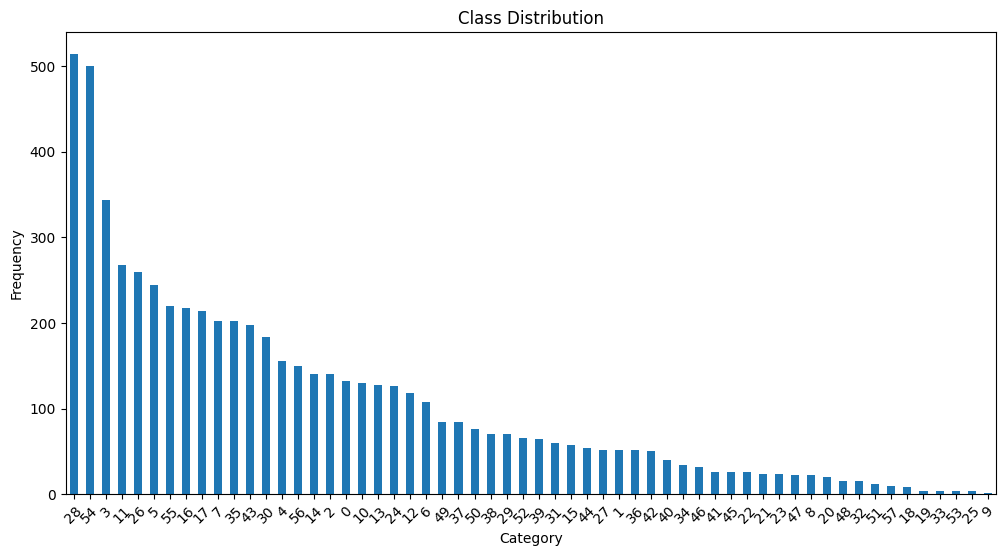

In [4]:
annotations_path = "C:\\Users\\Рамазан\\Desktop\\annotations.csv"
images_path = "C:\\Users\\Рамазан\\Desktop\\images" 

annotations = pd.read_csv(annotations_path)

print(annotations.head())

class_counts = annotations['category'].value_counts()
plt.figure(figsize=(12, 6))
class_counts.plot(kind='bar', title='Class Distribution')
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.xticks(rotation=45)  
plt.show()


In [5]:
def preprocess_image(file_name, x1, y1, x2, y2):
    img_path = os.path.join(images_path, file_name)
    img = load_img(img_path)  
    img = img.crop((x1, y1, x2, y2))  
    img = img.resize((128, 128))  
    img_array = img_to_array(img) / 255.0  
    return img_array

images = []
labels = []

for _, row in annotations.iterrows():
    try:
        img = preprocess_image(row['file_name'], row['x1'], row['y1'], row['x2'], row['y2'])
        images.append(img)
        labels.append(row['category'])
    except Exception as e:
        print(f"Error processing image {row['file_name']}: {e}")

images = np.array(images)
labels = np.array(labels)

labels_one_hot = to_categorical(labels, num_classes=58)


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(
    images, labels_one_hot, test_size=0.3, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 4314
Validation samples: 925
Test samples: 925


In [7]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)


Class Weights: {0: 0.8051201671891327, 1: 2.043766578249337, 2: 0.7591133004926108, 3: 0.3089414595028067, 4: 0.6812555260831122, 5: 0.4355568117580554, 6: 0.9840357598978289, 7: 0.5261181290542848, 8: 4.830721003134796, 9: 53.13793103448276, 10: 0.8175066312997348, 11: 0.39655172413793105, 12: 0.9006428988895383, 13: 0.8302801724137931, 14: 0.7591133004926108, 15: 1.8323424494649228, 16: 0.48750395444479594, 17: 0.49661617789236223, 18: 13.28448275862069, 19: 26.56896551724138, 20: 5.313793103448276, 21: 4.42816091954023, 22: 4.087533156498674, 23: 4.42816091954023, 24: 0.8434592227695676, 25: 26.56896551724138, 26: 0.4087533156498674, 27: 2.043766578249337, 28: 0.20676237756608076, 29: 1.5182266009852217, 30: 0.5775862068965517, 31: 1.771264367816092, 32: 6.642241379310345, 33: 26.56896551724138, 34: 3.125760649087221, 35: 0.5261181290542848, 36: 2.043766578249337, 37: 1.2651888341543513, 38: 1.5182266009852217, 39: 1.6605603448275863, 40: 2.656896551724138, 41: 4.087533156498674, 42

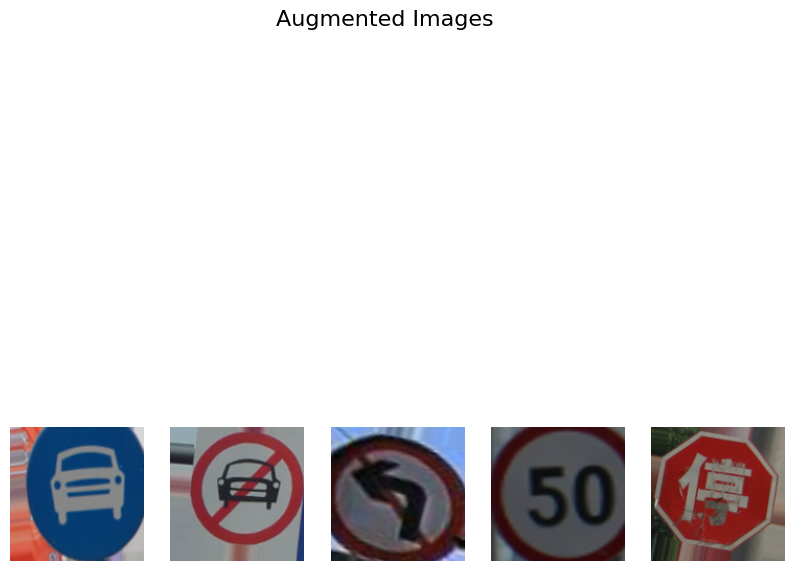

In [8]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

augmented_images = next(datagen.flow(X_train, y_train, batch_size=5)) 
plt.figure(figsize=(10, 10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(augmented_images[0][i])
    plt.axis('off')
plt.suptitle("Augmented Images", fontsize=16)
plt.show()


In [9]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False  

baseline_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(58, activation='softmax')  
])


baseline_model.compile(optimizer=Adam(learning_rate=0.0001),  
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


callbacks = [
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6),
    LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch > 5 else lr)
]


baseline_history = baseline_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


for layer in base_model.layers[-20:]:
    layer.trainable = True


baseline_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])


fine_tune_history = baseline_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=callbacks
)


Epoch 1/10


C:\Users\Рамазан\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


270/270 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - accuracy: 0.1199 - loss: 4.2089 - val_accuracy: 0.4649 - val_loss: 2.2347 - learning_rate: 1.0000e-04
Epoch 2/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.5268 - loss: 2.5088 - val_accuracy: 0.6551 - val_loss: 1.5346 - learning_rate: 1.0000e-04
Epoch 3/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 25s 94ms/step - accuracy: 0.6721 - loss: 1.7102 - val_accuracy: 0.7481 - val_loss: 1.1722 - learning_rate: 1.0000e-04
Epoch 4/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.7566 - loss: 1.2945 - val_accuracy: 0.7795 - val_loss: 0.9736 - learning_rate: 1.0000e-04
Epoch 5/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - accuracy: 0.7838 - loss: 1.0471 - val_accuracy: 0.8184 - val_loss: 0.8366 - learning_rate: 1.0000e-04
Epoch 6/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accuracy: 0.8321 - loss: 0.9165 - val_accuracy: 0.8454 - val_loss: 0.7293 - learning_rate: 1.0000e-04
Epoch 7/10
270/270 ━━━━━━━━━━━━━━━━━━━━ 22s 79ms/step - accurac

In [10]:
enhanced_model = Sequential([
    base_model,                     
    GlobalAveragePooling2D(),       
    BatchNormalization(),           
    Dropout(0.2),                   
    Dense(128, activation='relu'),  
    BatchNormalization(),           
    Dropout(0.2),                   
    Dense(58, activation='softmax') 
])

enhanced_model.compile(optimizer=Adam(learning_rate=0.0001),  
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),  
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),  
]

enhanced_history = enhanced_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),  
    validation_data=(X_val, y_val),                
    epochs=50,                                     
    class_weight=class_weights_dict,              
    callbacks=callbacks                           
)

enhanced_test_loss, enhanced_test_accuracy = enhanced_model.evaluate(X_test, y_test)
print(f"Enhanced Test Loss: {enhanced_test_loss}")
print(f"Enhanced Test Accuracy: {enhanced_test_accuracy}")


Epoch 1/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 32s 94ms/step - accuracy: 0.1692 - loss: 3.8736 - val_accuracy: 0.7178 - val_loss: 1.2742 - learning_rate: 1.0000e-04
Epoch 2/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 24s 88ms/step - accuracy: 0.6167 - loss: 1.6106 - val_accuracy: 0.8389 - val_loss: 0.6530 - learning_rate: 1.0000e-04
Epoch 3/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 24s 87ms/step - accuracy: 0.7659 - loss: 0.9304 - val_accuracy: 0.8908 - val_loss: 0.4623 - learning_rate: 1.0000e-04
Epoch 4/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 24s 89ms/step - accuracy: 0.8330 - loss: 0.7020 - val_accuracy: 0.9103 - val_loss: 0.3814 - learning_rate: 1.0000e-04
Epoch 5/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 28s 105ms/step - accuracy: 0.8698 - loss: 0.5341 - val_accuracy: 0.9243 - val_loss: 0.3057 - learning_rate: 1.0000e-04
Epoch 6/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 32s 116ms/step - accuracy: 0.8852 - loss: 0.4427 - val_accuracy: 0.9427 - val_loss: 0.2272 - learning_rate: 1.0000e-04
Epoch 7/50
270/270 ━━━━━━━━━━━━━━━━━━━━ 33s 120ms/

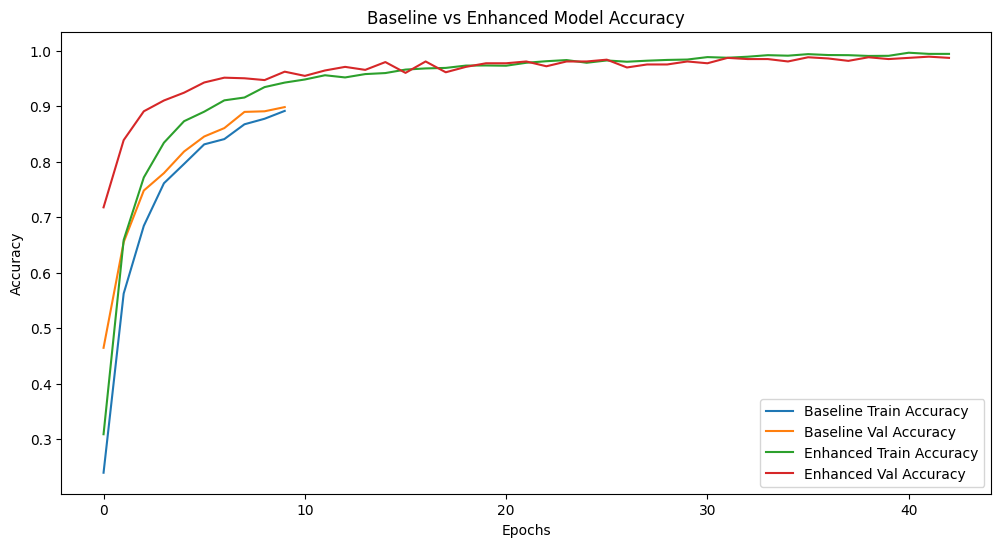

In [11]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(baseline_history.history['accuracy'], label='Baseline Train Accuracy')
plt.plot(baseline_history.history['val_accuracy'], label='Baseline Val Accuracy')
plt.plot(enhanced_history.history['accuracy'], label='Enhanced Train Accuracy')
plt.plot(enhanced_history.history['val_accuracy'], label='Enhanced Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Baseline vs Enhanced Model Accuracy')
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:

y_pred_probs = enhanced_model.predict(X_test) 
y_pred = np.argmax(y_pred_probs, axis=1)       
y_true = np.argmax(y_test, axis=1)             


29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step


In [14]:
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Set Accuracy: {accuracy * 100:.2f}%")


Test Set Accuracy: 99.14%


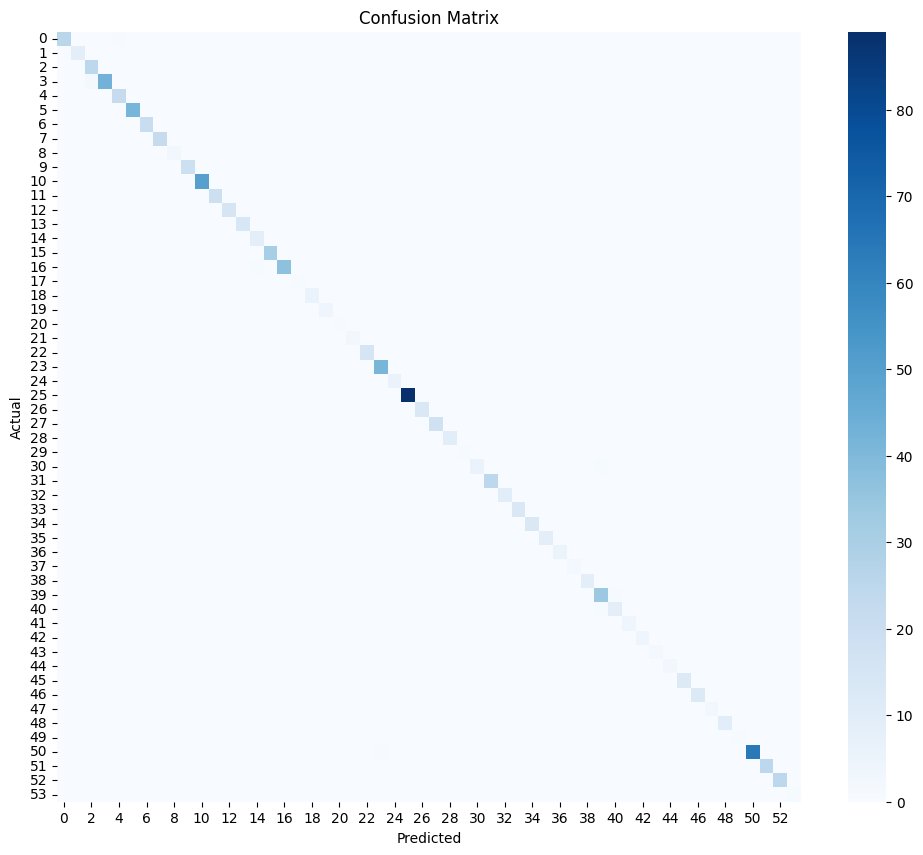

In [15]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [16]:
unique_classes = np.unique(y_true)  
class_names = [f'Class {i}' for i in unique_classes]  


y_pred_probs = enhanced_model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=1)      

report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n")
print(report)

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step
Classification Report:

              precision    recall  f1-score   support

     Class 0       1.00      0.96      0.98        27
     Class 1       1.00      1.00      1.00         9
     Class 2       0.93      1.00      0.96        25
     Class 3       1.00      0.96      0.98        45
     Class 4       0.96      1.00      0.98        22
     Class 5       1.00      1.00      1.00        42
     Class 6       1.00      1.00      1.00        21
     Class 7       1.00      1.00      1.00        22
     Class 8       1.00      1.00      1.00         3
    Class 10       1.00      1.00      1.00        19
    Class 11       1.00      1.00      1.00        50
    Class 12       1.00      1.00      1.00        19
    Class 13       1.00      1.00      1.00        15
    Class 14       1.00      1.00      1.00        14
    Class 15       0.90      1.00      0.95         9
    Class 16       1.00      1.00      1.00        31
    Class 17    

In [17]:
enhanced_model.save('enhanced_model.h5')
